In [ ]:
import pandas as pd
import requests

# ----------------------------
# 1. World Bank API Fetch
# ----------------------------

def fetch_worldbank(indicator, start=2010, end=2024):
    """
    Fetch World Bank data for a given indicator
    indicator = World Bank indicator code
    Example codes:
        FP.CPI.TOTL -> Consumer Price Index (2010=100)
        FP.CPI.TOTL.ZG -> Inflation (% annual)
        NY.GDP.PCAP.PP.CD -> GDP per capita, PPP (current international $)
    """
    url = f"http://api.worldbank.org/v2/country/all/indicator/{indicator}?format=json&date={start}:{end}&per_page=20000"
    response = requests.get(url)
    data = response.json()[1]
    df = pd.DataFrame(data)
    df = df[["country", "date", "value"]]
    df["country"] = df["country"].apply(lambda x: x["value"])
    df.rename(columns={"date": "year", "value": indicator}, inplace=True)
    return df

# Fetch CPI, Inflation, and GDP per capita PPP
cpi = fetch_worldbank("FP.CPI.TOTL")        # Consumer Price Index
inflation = fetch_worldbank("FP.CPI.TOTL.ZG")  # Inflation (% annual)
gdp_ppp = fetch_worldbank("NY.GDP.PCAP.PP.CD") # GDP per capita PPP

# Merge datasets
df = cpi.merge(inflation, on=["country", "year"], how="left")
df = df.merge(gdp_ppp, on=["country", "year"], how="left")

print(df.head())

# ----------------------------
# 2. Numbeo Data (Option A: Manual CSV Download)
# ----------------------------
# If you download Numbeo data manually (CSV), just load it:
numbeo = pd.read_csv("/content/Cost_of_Living_Index_by_Country_2024.csv")
print(numbeo.head())
# ----------------------------
# 3. Numbeo API (Option B: Premium API)
# ----------------------------
# Requires API key from Numbeo
# Example endpoint: https://www.numbeo.com/api/docs.jsp
# response = requests.get("https://www.numbeo.com/api/city_prices?api_key=YOUR_KEY&city=New%20York")
# numbeo_data = response.json()


                       country  year  FP.CPI.TOTL  FP.CPI.TOTL.ZG  \
0  Africa Eastern and Southern  2024          NaN        4.425471   
1  Africa Eastern and Southern  2023          NaN        7.126975   
2  Africa Eastern and Southern  2022          NaN       10.773751   
3  Africa Eastern and Southern  2021          NaN        7.240978   
4  Africa Eastern and Southern  2020          NaN        5.405162   

   NY.GDP.PCAP.PP.CD  
0        4481.246847  
1        4352.490897  
2        4229.086486  
3        3907.249127  
4        3629.566978  
   Rank      Country  Cost of Living Index  Rent Index  \
0     1  Switzerland                 101.1        46.5   
1     2      Bahamas                  85.0        36.7   
2     3      Iceland                  83.0        39.2   
3     4    Singapore                  76.7        67.2   
4     5     Barbados                  76.6        19.0   

   Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                   

In [ ]:
numbeo.columns = numbeo.columns.str.strip().str.replace(" ", "_")
numbeo['Country'] = numbeo['Country'].str.strip()

# Example: keep main metrics only
numbeo = numbeo[['Country', 'Cost_of_Living_Index', 'Rent_Index',
                 'Groceries_Index', 'Restaurant_Price_Index',
                 'Local_Purchasing_Power_Index']]


In [ ]:
from datetime import datetime
current_year = datetime.now().year

# Example (simplified) - fetch last 10 years of data
cpi = fetch_worldbank("FP.CPI.TOTL", start=2014, end=current_year)
gdp_ppp = fetch_worldbank("NY.GDP.PCAP.PP.CD", start=2014, end=current_year)
inflation = fetch_worldbank("FP.CPI.TOTL.ZG", start=2014, end=current_year)


In [ ]:
# Convert year column to integer
for df in [cpi, gdp_ppp, inflation]:
    df['year'] = df['year'].astype(int)
    df.dropna(subset=[df.columns[-1]], inplace=True)


In [ ]:
# Get latest year from World Bank datasets
latest_year = gdp_ppp['year'].max()

# Subset World Bank data for latest year
worldbank = gdp_ppp[gdp_ppp['year'] == latest_year].merge(
    inflation[inflation['year'] == latest_year],
    on=['country', 'year'],
    how='left'
).merge(
    cpi[cpi['year'] == latest_year],
    on=['country', 'year'],
    how='left'
)

# Rename for clarity
worldbank.rename(columns={
    'country': 'Country',
    'NY.GDP.PCAP.PP.CD': 'GDP_per_capita_PPP',
    'FP.CPI.TOTL.ZG': 'Inflation_percent',
    'FP.CPI.TOTL': 'CPI_index'
}, inplace=True)

# Merge with Numbeo
merged = numbeo.merge(worldbank, on='Country', how='inner')
merged.head()


,Country,Cost_of_Living_Index,Rent_Index,Groceries_Index,Restaurant_Price_Index,Local_Purchasing_Power_Index,year,GDP_per_capita_PPP,Inflation_percent,CPI_index
0,Switzerland,101.1,46.5,109.1,97.0,158.7,2024,93818.707481,1.062340,105.509114
1,Iceland,83.0,39.2,88.4,86.8,120.3,2024,78258.759251,5.856838,172.757931
2,Singapore,76.7,67.2,74.6,50.4,111.1,2024,150689.301626,2.389511,133.157196
3,Barbados,76.6,19.0,80.8,69.4,43.5,2024,22671.946686,-0.462229,170.100168
4,Norway,76.0,26.2,79.0,73.5,114.7,2024,101031.587517,3.145301,145.109040


In [ ]:
merged['Affordability_Ratio'] = merged['Cost_of_Living_Index'] / merged['GDP_per_capita_PPP']


In [ ]:
corr = merged[['Cost_of_Living_Index', 'GDP_per_capita_PPP',
               'Inflation_percent', 'Affordability_Ratio']].corr()
print(corr)


                      Cost_of_Living_Index  GDP_per_capita_PPP  \
Cost_of_Living_Index              1.000000            0.777200   
GDP_per_capita_PPP                0.777200            1.000000   
Inflation_percent                -0.298656           -0.284812   
Affordability_Ratio              -0.341985           -0.539702   

                      Inflation_percent  Affordability_Ratio  
Cost_of_Living_Index          -0.298656            -0.341985  
GDP_per_capita_PPP            -0.284812            -0.539702  
Inflation_percent              1.000000             0.329892  
Affordability_Ratio            0.329892             1.000000  


/tmp/ipython-input-2454817064.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


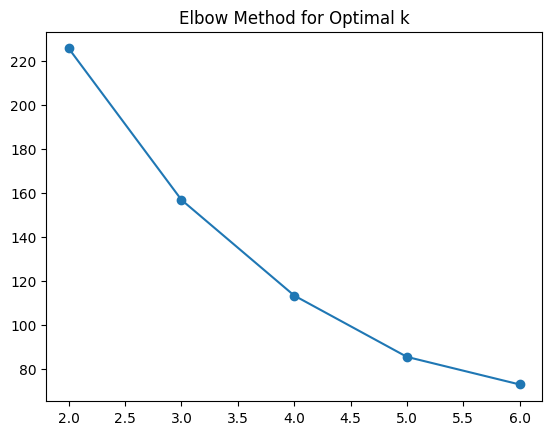

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = merged[['Cost_of_Living_Index', 'Inflation_percent', 'GDP_per_capita_PPP', 'Affordability_Ratio']]

# Drop rows with missing values in the clustering columns
X.dropna(inplace=True)
merged_cleaned = merged.loc[X.index].copy() # Keep track of original index for merging back

X_scaled = StandardScaler().fit_transform(X)

# Find optimal k
inertia = []
for k in range(2,7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init for robustness
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2,7), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.show()

# Cluster into 3 groups (assuming 3 is chosen from the elbow method)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init for robustness
merged_cleaned['Cluster'] = kmeans.fit_predict(X_scaled)

# Merge the cluster labels back to the original dataframe
merged = merged.merge(merged_cleaned[['Cluster']], left_index=True, right_index=True, how='left')

# Label them manually later as Affordable / Expensive / Volatile

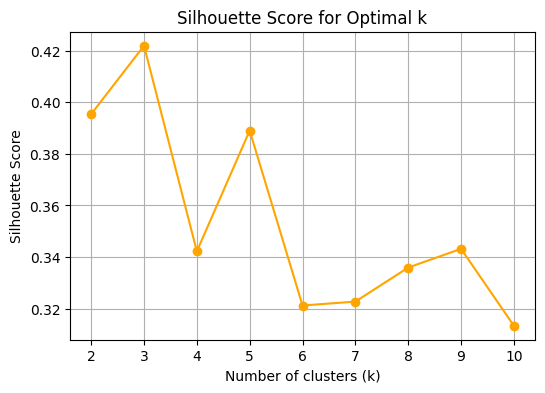

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(range(2,11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [ ]:
features = ['Cost_of_Living_Index', 'Inflation_percent', 'GDP_per_capita_PPP', 'Affordability_Ratio']
cluster_summary = merged.groupby('Cluster')[features].mean().round(2)
print(cluster_summary)

         Cost_of_Living_Index  Inflation_percent  GDP_per_capita_PPP  \
Cluster                                                                
0.0                     31.92              11.19             6515.47   
1.0                     35.33               3.49            26829.71   
2.0                     62.47               2.27            75507.94   

         Affordability_Ratio  
Cluster                       
0.0                     0.01  
1.0                     0.00  
2.0                     0.00  


In [ ]:
merged.to_csv("global_cost_of_living_merged.csv", index=False)


In [ ]:
import pandas as pd

merged = pd.read_csv("global_cost_of_living_merged.csv")
merged.info()
merged.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       100 non-null    object 
 1   Cost_of_Living_Index          100 non-null    float64
 2   Rent_Index                    100 non-null    float64
 3   Groceries_Index               100 non-null    float64
 4   Restaurant_Price_Index        100 non-null    float64
 5   Local_Purchasing_Power_Index  100 non-null    float64
 6   year                          100 non-null    int64  
 7   GDP_per_capita_PPP            100 non-null    float64
 8   Inflation_percent             92 non-null     float64
 9   CPI_index                     92 non-null     float64
 10  Affordability_Ratio           100 non-null    float64
 11  Cluster                       92 non-null     float64
dtypes: float64(10), int64(1), object(1)
memory usage: 9.5+ KB


,Country,Cost_of_Living_Index,Rent_Index,Groceries_Index,Restaurant_Price_Index,Local_Purchasing_Power_Index,year,GDP_per_capita_PPP,Inflation_percent,CPI_index,Affordability_Ratio,Cluster
0,Switzerland,101.1,46.5,109.1,97.0,158.7,2024,93818.707481,1.062340,105.509114,0.001078,2.0
1,Iceland,83.0,39.2,88.4,86.8,120.3,2024,78258.759251,5.856838,172.757931,0.001061,2.0
2,Singapore,76.7,67.2,74.6,50.4,111.1,2024,150689.301626,2.389511,133.157196,0.000509,2.0
3,Barbados,76.6,19.0,80.8,69.4,43.5,2024,22671.946686,-0.462229,170.100168,0.003379,2.0
4,Norway,76.0,26.2,79.0,73.5,114.7,2024,101031.587517,3.145301,145.109040,0.000752,2.0


In [ ]:
summary = merged.groupby('Cluster')[['Cost_of_Living_Index',
                                           'GDP_per_capita_PPP',
                                           'Inflation_percent',
                                           'Affordability_Ratio']].mean().round(2)
print(summary)


         Cost_of_Living_Index  GDP_per_capita_PPP  Inflation_percent  \
Cluster                                                                
0.0                     31.92             6515.47              11.19   
1.0                     35.33            26829.71               3.49   
2.0                     62.47            75507.94               2.27   

         Affordability_Ratio  
Cluster                       
0.0                     0.01  
1.0                     0.00  
2.0                     0.00  


In [ ]:
import plotly.express as px
fig = px.scatter(
    merged,
    x='GDP_per_capita_PPP',
    y='Cost_of_Living_Index',
    color='Cluster',
    hover_name='Country',
    title='GDP vs Cost of Living by Cluster'
)
fig.show()

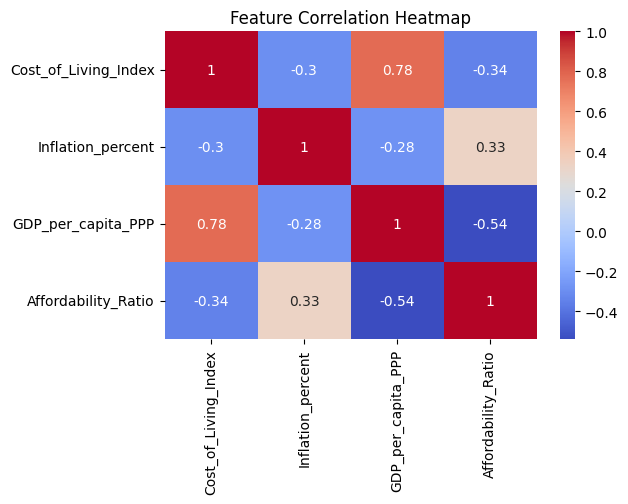

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(merged[['Cost_of_Living_Index','Inflation_percent',
                    'GDP_per_capita_PPP','Affordability_Ratio']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
import plotly.express as px

fig = px.choropleth(
    merged,
    locations="Country",
    locationmode="country names",
    color="Cluster",
    hover_name="Country",
    color_discrete_map={
        'Affordable': 'green',
        'Expensive': 'red',
        'Volatile': 'orange'
    },
    title="Global Cost of Living Clusters (Affordable / Expensive / Volatile)"
)
fig.show()
